In [ ]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay





--- TRAINING SET ---
              img_id     class_id
239   img_100754.jpg  using_phone
2603   img_66806.jpg  using_phone
3817   img_96164.jpg  using_phone

Sample image paths:
../split_data\training\img_100754.jpg
../split_data\training\img_66806.jpg
../split_data\training\img_96164.jpg


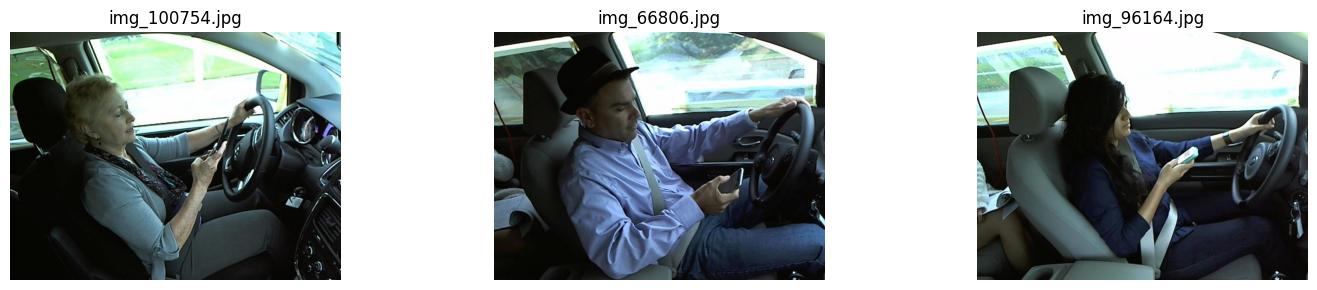


--- VALIDATION SET ---
             img_id     class_id
450   img_16352.jpg     drinking
1174  img_40743.jpg  using_phone
1192  img_41900.jpg  using_phone

Sample image paths:
../split_data\validation\img_16352.jpg
../split_data\validation\img_40743.jpg
../split_data\validation\img_41900.jpg


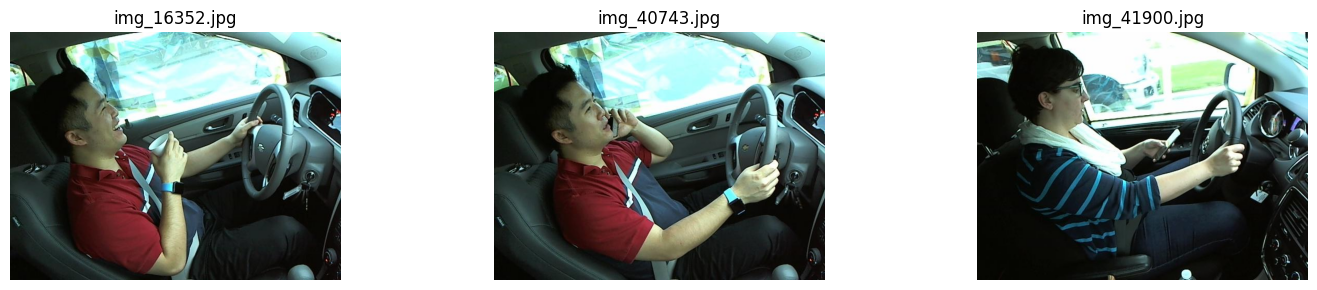


--- TESTING SET ---
             img_id     class_id
450   img_22243.jpg     drinking
1174  img_14508.jpg  using_phone
1192  img_96117.jpg     drinking

Sample image paths:
../split_data\testing\img_22243.jpg
../split_data\testing\img_14508.jpg
../split_data\testing\img_96117.jpg


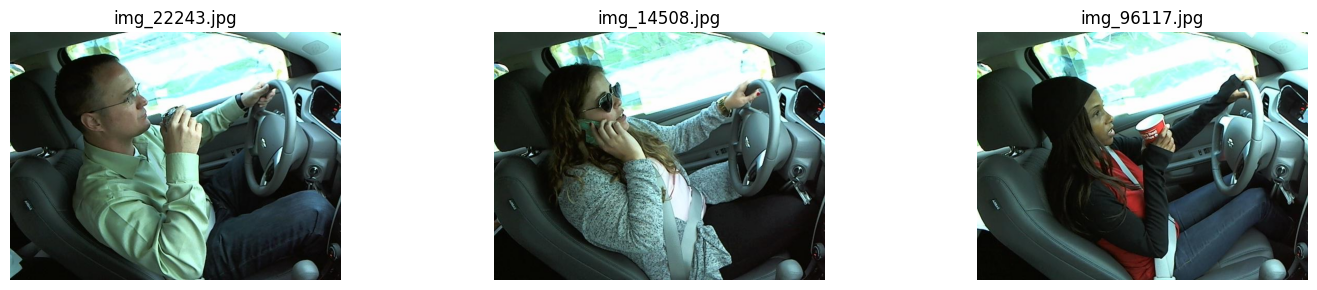

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2

# Base path
base_path = "../split_data"

# function to display paths and image previews
def show_examples(split_name, show_images=True, n=3):
    print(f"\n--- {split_name.upper()} SET ---")

    # Loading CSV and image folder
    df = pd.read_csv(os.path.join(base_path, f"{split_name}_data.csv"))
    folder = os.path.join(base_path, split_name)

    # Showing sample DataFrame rows
    sample_df = df.sample(n, random_state=42)
    print(sample_df[["img_id", "class_id"]])

    # Showing image paths
    print("\nSample image paths:")
    for img_id in sample_df["img_id"]:
        print(os.path.join(folder, img_id))

    # Showing image previews
    if show_images:
        plt.figure(figsize=(15, 3))
        for i, img_id in enumerate(sample_df["img_id"]):
            img_path = os.path.join(folder, img_id)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                plt.subplot(1, n, i + 1)
                plt.imshow(img)
                plt.title(f"{img_id}")
                plt.axis("off")
        plt.tight_layout()
        plt.show()

# Displaying examples
for split in ["training", "validation", "testing"]:
    show_examples(split, show_images=True, n=3)


In [ ]:


# Parameters
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

# Base directory and CSVs
base_dir = "../split_data"

# Augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    brightness_range=[0.9, 1.1],
    horizontal_flip=True
)



# Validation and test: only rescaling
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Training generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=pd.read_csv(os.path.join(base_dir, "training_data.csv")),
    directory=os.path.join(base_dir, "training"),
    x_col="img_id",
    y_col="class_id",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    seed=SEED
)

# Validation generator
val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=pd.read_csv(os.path.join(base_dir, "validation_data.csv")),
    directory=os.path.join(base_dir, "validation"),
    x_col="img_id",
    y_col="class_id",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

# Testing generator
test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=pd.read_csv(os.path.join(base_dir, "testing_data.csv")),
    directory=os.path.join(base_dir, "testing"),
    x_col="img_id",
    y_col="class_id",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)


Found 8442 validated image filenames belonging to 3 classes.
Found 2814 validated image filenames belonging to 3 classes.
Found 2814 validated image filenames belonging to 3 classes.


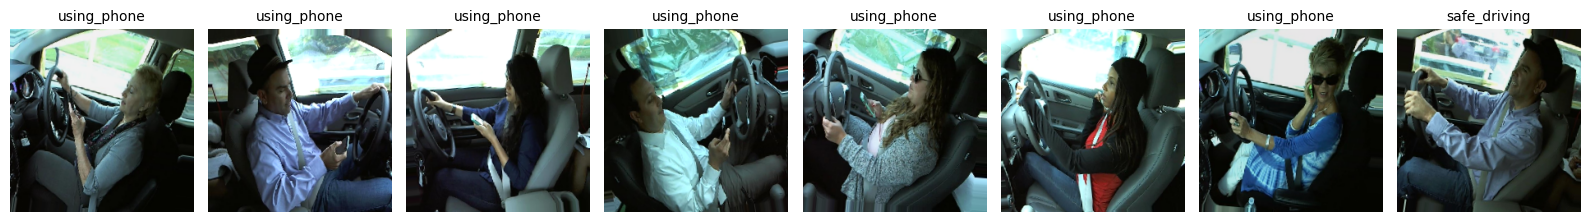

In [ ]:


# Getting one batch of augmented images and labels
images, labels = next(train_generator)

# Plot the first 8 images from the batch
plt.figure(figsize=(16, 4))
for i in range(8):
    plt.subplot(1, 8, i + 1)
    plt.imshow(images[i])
    label_index = np.argmax(labels[i])
    label_name = list(train_generator.class_indices.keys())[label_index]
    plt.title(label_name, fontsize=10)
    plt.axis("off")
plt.tight_layout()
plt.show()


In [ ]:


# Building the baseline CNN
baseline_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 classes
])

# Compiling the model
baseline_model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("baseline_model.keras", monitor='val_accuracy', save_best_only=True)

baseline_model.summary()


C:\Users\nisha\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    11,944,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,963,587 (45.64 MB)

 Trainable params: 11,963,587 (45.64 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:


# Defining class labels as per your training generator
class_names = list(train_generator.class_indices.keys())  # ['drinking', 'safe_driving', 'using_phone']

# Map y labels in training CSV to numeric indices
y_train = pd.read_csv(os.path.join(base_dir, "training_data.csv"))["class_id"].map({k: v for v, k in enumerate(class_names)})

# Computing weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Converting to dict for Keras
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: np.float64(2.0172043010752687), 1: np.float64(1.884795713328868), 2: np.float64(0.5066618653222903)}


In [12]:
history1 = baseline_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop, checkpoint],
    class_weight=class_weights
)


C:\Users\nisha\AppData\Roaming\Python\Python39\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 118s 446ms/step - accuracy: 0.2946 - loss: 1.4332 - val_accuracy: 0.6439 - val_loss: 0.9782
Epoch 2/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 110s 416ms/step - accuracy: 0.4992 - loss: 0.9432 - val_accuracy: 0.7267 - val_loss: 0.6233
Epoch 3/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 108s 408ms/step - accuracy: 0.5880 - loss: 0.6904 - val_accuracy: 0.7751 - val_loss: 0.5040
Epoch 4/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 110s 416ms/step - accuracy: 0.6467 - loss: 0.5906 - val_accuracy: 0.8255 - val_loss: 0.4234
Epoch 5/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 107s 405ms/step - accuracy: 0.6557 - loss: 0.5868 - val_accuracy: 0.7889 - val_loss: 0.4506
Epoch 6/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 109s 412ms/step - accuracy: 0.7045 - loss: 0.5199 - val_accuracy: 0.8724 - val_loss: 0.3056
Epoch 7/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 108s 408ms/step - accuracy: 0.7224 - loss: 0.4914 - val_accuracy: 0.8849 - val_loss: 0.3022
Epoch 8/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 108s 408ms/step - accuracy: 0.7588 -

88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step


<Figure size 600x600 with 0 Axes>

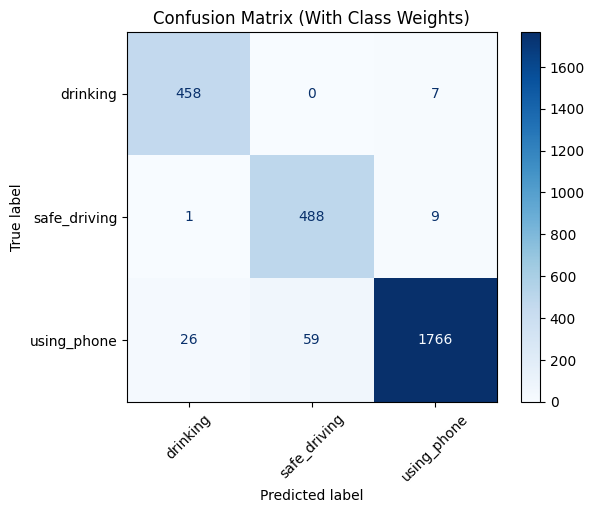

Classification Report (With Class Weights):
              precision    recall  f1-score   support

    drinking       0.94      0.98      0.96       465
safe_driving       0.89      0.98      0.93       498
 using_phone       0.99      0.95      0.97      1851

    accuracy                           0.96      2814
   macro avg       0.94      0.97      0.96      2814
weighted avg       0.97      0.96      0.96      2814



In [ ]:


# Predicting on test data
y_pred_probs = baseline_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# True labels
y_true_classes = test_generator.classes

# Class label mapping
class_labels = list(test_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix (With Class Weights)")
plt.show()

# Classification Report
print("Classification Report (With Class Weights):")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_labels))


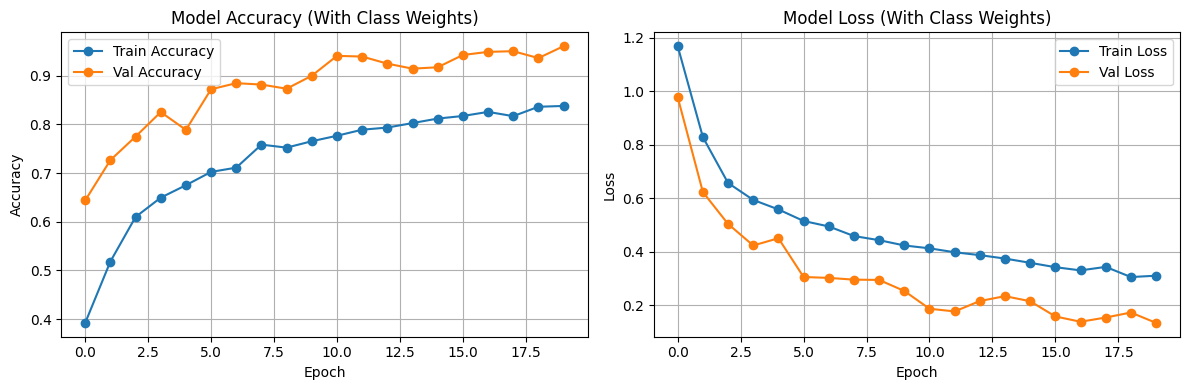

In [ ]:


# Accuracy and Loss Plot
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history1.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Model Accuracy (With Class Weights)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'], label='Train Loss', marker='o')
plt.plot(history1.history['val_loss'], label='Val Loss', marker='o')
plt.title('Model Loss (With Class Weights)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
